#Sarthak kumar,  015042,  BDA-01
#Covid-19 Tweets NLP using Tensorflow
For this project we are trying classify the sentiment of tweets regarding Covid-19. \ We are going to use Tensorflow and Keras to perform NLP, more specifically we will be using techinques such as:

Tokenizing
Padding,
Embedding
GRU
LSTM
Convolutions
Dropout
There will also be some data cleaning and reduction of vocabulary to increase the performance of our models.

We will achieve about 88% accuracy on the validation data.

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Corona_NLP_test.csv to Corona_NLP_test.csv
Saving Corona_NLP_train.csv to Corona_NLP_train.csv


In [ ]:
df_training = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin_1')
df_validation = pd.read_csv('Corona_NLP_test.csv', encoding = 'latin_1')


In [ ]:
df_training.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df_validation.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
training = df_training.copy()
validation = df_validation.copy()

We will only be using the Original Tweet column to predict the Sentiment.

In [ ]:
training = training[['OriginalTweet', 'Sentiment']]
validation = validation[['OriginalTweet', 'Sentiment']]

#Missing Values
Lets check for any missing values.

In [ ]:
training.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [ ]:
validation.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

Take a look on the different sentiment categories.

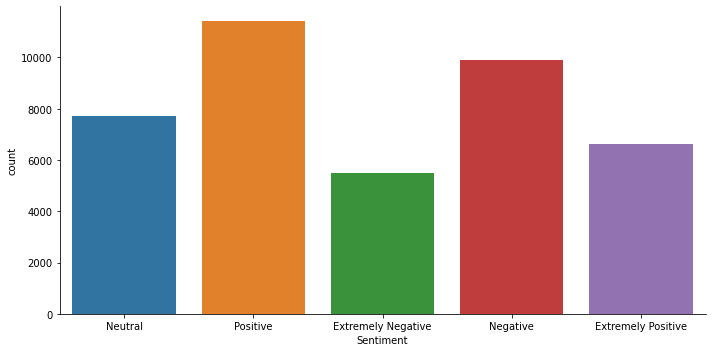

In [ ]:
sns.catplot(x = 'Sentiment', kind = 'count', data = training, height = 5, aspect = 2)

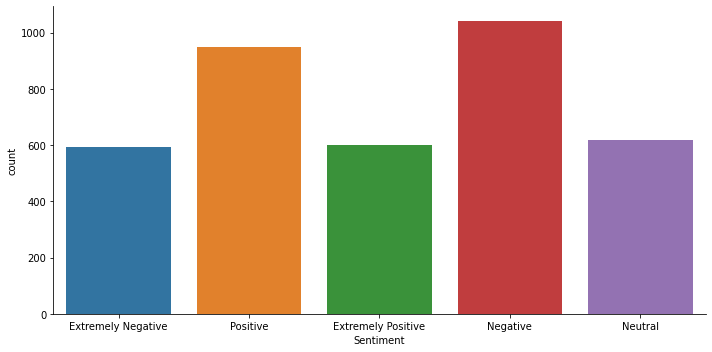

In [ ]:
sns.catplot(x = 'Sentiment', kind = 'count', data = validation, height = 5, aspect = 2)


#Mapping the Sentiment Column
Now we recode the Sentiment column into numerical values. We will only use 3 categories, Negative, Neutral and Positive.

In [ ]:
l = {'Extremely Negative': 0,
     'Negative': 0,
     'Neutral': 1,
     'Positive': 2,
     'Extremely Positive': 2}

In [ ]:
training['Sentiment'] = training['Sentiment'].map(l)
validation['Sentiment'] = validation['Sentiment'].map(l)

In [ ]:
training['Sentiment'].value_counts

<bound method IndexOpsMixin.value_counts of 0        1
1        2
2        2
3        2
4        0
        ..
41152    1
41153    0
41154    2
41155    1
41156    0
Name: Sentiment, Length: 41157, dtype: int64>

In [ ]:
validation['Sentiment'].value_counts

<bound method IndexOpsMixin.value_counts of 0       0
1       2
2       2
3       0
4       1
       ..
3793    2
3794    0
3795    1
3796    0
3797    2
Name: Sentiment, Length: 3798, dtype: int64>

#Cleaning
Now we clean the tweets by removing the urls and the people tagged from them. Also we are going to remove tweets that are shorter than 20 characters from the training set.

In [ ]:
training['OriginalTweet'] = training['OriginalTweet'].str.replace(r'http\S+', '', regex = True)
training['OriginalTweet'] = training['OriginalTweet'].str.replace(r'@\S+', '', regex = True)
validation['OriginalTweet'] = validation['OriginalTweet'].str.replace(r'http\S+', '', regex = True)
validation['OriginalTweet'] = validation['OriginalTweet'].str.replace(r'@\S+', '', regex = True)
print(training['OriginalTweet'])

0                                                and  and 
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
3        My food stock is not the only one which is emp...
4        Me, ready to go at supermarket during the #COV...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know itÂs getting tough when   is rationi...
41155    Is it wrong that the smell of hand sanitizer i...
41156     Well new/used Rift S are going for $700.00 on...
Name: OriginalTweet, Length: 41157, dtype: object


In [ ]:
print(training.shape)
training = training[(training['OriginalTweet'].str.len() > 20)]
print(training.shape)

(41157, 2)
(41078, 2)


#Tokenize
For the tokenization everything is quite standard, we tokenize and then we pad all the sentences so that they have the same length. The max length of a sentence is 120 words which sufficient. We have decreased the vocabulary of the Tokenizer from about 50000 to 6000 in order to reduce overfitting since this will make vocabulary consist of only the 6000 most common words from the training data.

In [ ]:
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'

training_sentences = training['OriginalTweet']
training_labels = training['Sentiment']

validation_sentences = validation['OriginalTweet']
validation_labels = validation['Sentiment']

tokenizer = Tokenizer(oov_token = oov_tok, num_words = 6000)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index) +1

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen = max_length, truncating = trunc_type)

#Models
I am going to try GRU

I am going to use a callback so that the training stops after 5 epochs if the validation accuarcy is not increasing. That should remove the problem of overfitting. Also the model will restore the weights for the epoch with the best validation accuracy.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

#GRU

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv1D(128, 5, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 1),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv1D(256, 5, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           832656    
_________________________________________________________________
dropout (Dropout)            (None, 120, 16)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 116, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 116, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 112, 256)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 256)          0

In [ ]:
history = model.fit(padded, 
                    np.array(training_labels), 
                    epochs = 20, 
                    validation_data = (validation_padded, np.array(validation_labels)),
                    callbacks = [callback])

Text(0, 0.5, 'Accuarcy')

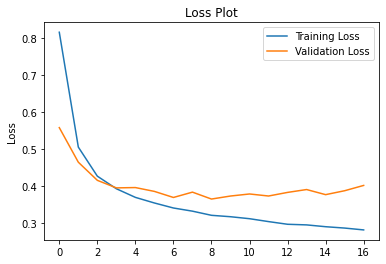

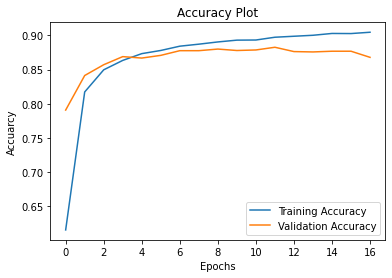

In [40]:
loss = history.history['loss']
acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Accuarcy')

While our accuracy on the training data is increasing our accuracy on the validation data is decreasing/stagnant which is sign that we are overfitting. The callback went in and stoppped the training early.